In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image as im
import random

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')



### Uplodaing the data

In [2]:
train_dir = r'C:\Users\meirk\Desktop\train\train/'

train_images_filepath = [train_dir + last_file_name for last_file_name in os.listdir(train_dir)]
print("Done")
train_dogs_filepaths = [train_dir + dog_file_name for dog_file_name in os.listdir(train_dir) if 'dog' in dog_file_name]
train_cats_filepaths = [train_dir + cat_file_name for cat_file_name in os.listdir(train_dir) if 'cat' in cat_file_name]
print("Done")

Done
Done


(374, 500, 3)
(374, 500, 3)


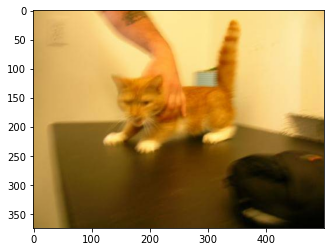

In [3]:
img = cv2.imread(train_images_filepath[0])
print(img.shape)
#img = cv2.resize(img, (64,64))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
print(img.shape)
plt.imshow(img)

### Preparing the data- making DataFrame

In [4]:
def read_image(file_path):

    img = cv2.imread(file_path,cv2.IMREAD_COLOR)
    #resizing the image to 64,64 format
    return cv2.resize(img, (64, 64))

#### Note: 
1. Read_image return the image after resizing it to 64X64 in ordr to make sure that all images are in the same foramt.
2. As can be seen, the imgaes are not grayscaled. In first attempt i did grayscale them, but score where lower.

In [5]:
def prep_data(images):
    m = len(images)
    n_x = 12288
    X = np.ndarray((m, n_x), dtype=np.uint8)
    y = np.zeros((m, 1))

    for i, image_file in enumerate(images):
        image = read_image(image_file)
       # image = plt.imread(image_file, 0)
        X[i, :] = np.squeeze(image.reshape((n_x, 1)))
        #X[i,:] = np.array(image)
        #chainging cats to 0's and dogs to 1's
        if '/dog' in image_file:
            y[i, 0] = 1
        elif '/cat' in image_file:
             y[i, 0] = 0
        
    return X, y

In [6]:
data,target = prep_data(train_images_filepath)
#X_dogs, y_dogs = prep_data(train_dogs_filepaths)
#x_cats, y_cats = prep_data(train_cats_filepaths)

In [7]:
data_df = pd.DataFrame(data)
data_df

0      1      2      3      4      5      6      7      8      9      \
0         90    167    206     96    173    212    101    179    222    106   
1         43     44     40     49     42     39     38     37     33     31   
2         54     45     40     59     45     41     58     47     42     68   
3        217    222    220    218    223    222    230    231    231    230   
4         73    110    138     81    118    146     43     81    110     47   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
24995    107    144    148    108    145    149    111    148    152    113   
24996     56     84    114     54     81    107     55     80    104     64   
24997     34     37     43     44     47     53     45     46     48     36   
24998    254    254    254    243    242    254    212    218    254    168   
24999    229    240    247    231    241    249    230    240    247    230   

       ...  12278  12279  12280  12281  12282  12283  12284  12285  12286  \
0      ...      2      0      2      2      0      2      2      0      2   
1      ...     66     63     67     85     59     63     81     19     26   
2      ...    155      4    167    174      4    192    193      9    175   
3      ...    205    220    221    217    211    214    214    208    212   
4      ...    111     77    105    117     65     94    104     62     86   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
24995  ...    178    134    169    179    134    169    179    135    170   
24996  ...     98     55     84    105     80    111    132     40     65   
24997  ...    122    164    206    243     96    133    157    118    162   
24998  ...    105    116    113    136    114    111    127    113    113   
24999  ...    254    254    254    254    254    254    254    254    254   

       12287  
0          2  
1         38  
2        180  
3        216  
4         98  
...      ...  
24995    180  
24996     87  
24997    205  
24998    129  
24999    254  

[25000 rows x 12288 columns]

## Data visualization

In [8]:
data_df.isna().sum()

0        0
1        0
2        0
3        0
4        0
        ..
12283    0
12284    0
12285    0
12286    0
12287    0
Length: 12288, dtype: int64

<module 'seaborn' from 'C:\\Users\\meirk\\anaconda3\\lib\\site-packages\\seaborn\\__init__.py'>

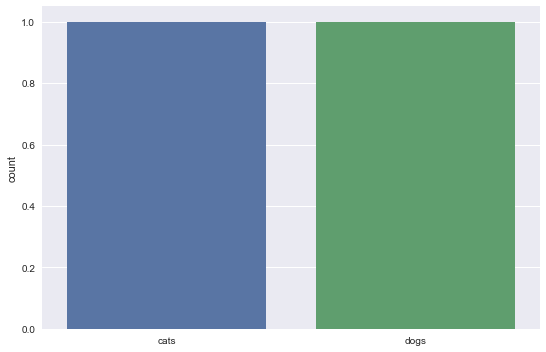

In [9]:
plt.style.use('seaborn')
labels = pd.DataFrame(data=target, columns=['label'])
counts = labels.value_counts()
sns.catplot(data=counts,kind='count',height=5,aspect=1.5,x=['cats','dogs'])
sns

Lets look on some random images to make sure the data did uploaded in gratscale

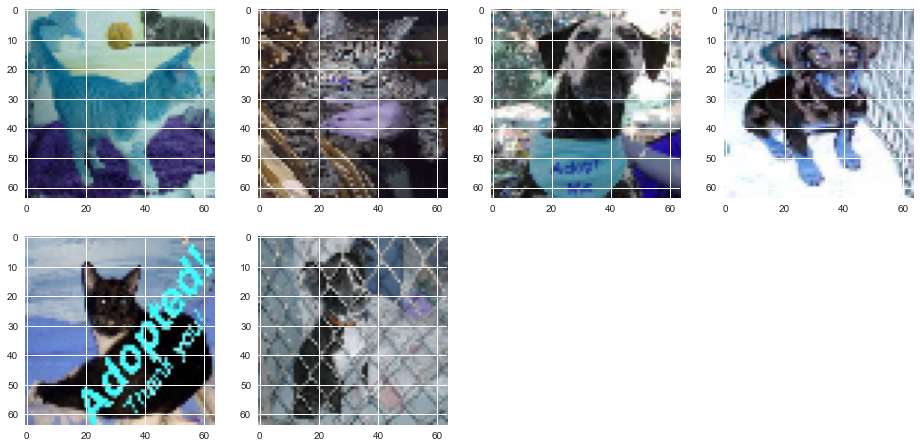

In [10]:
plt.figure(figsize=(16,16))

for i in range(0,6):
    index = random.randint(0,24999)
   # plt.imshow(data[index].reshape(64,64),interpolation='nearest')
    fig = plt.subplot(4,4,i+1)
   # fig.axis('off')
    #fig.imshow(data[index].reshape(64,64)) 
    fig.imshow(data[index].reshape(64,64,3))

### Removing bad images
I noticed there are some images which do not present their label clearly,some even labeld incorrectly! I want to remove them.
<br>First lets look at some of them:

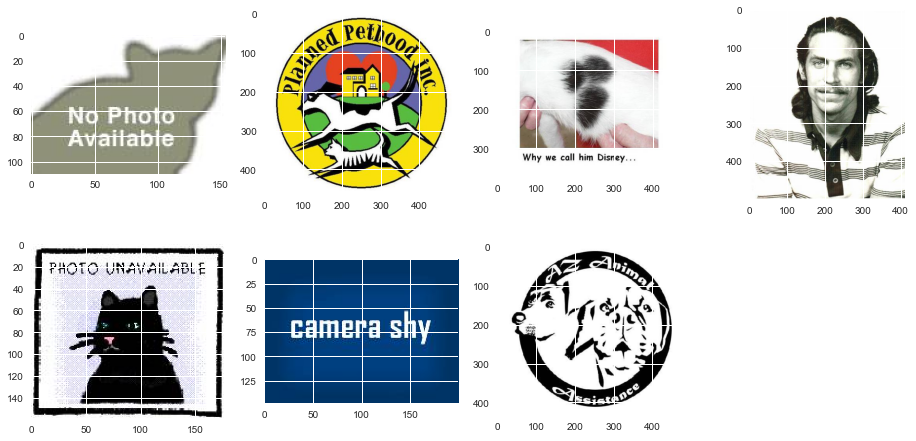

In [11]:
bad_images = [4965,6599,8297,9587,1742,20118,12715]
plt.figure(figsize=(16,16))
i=0

for image in bad_images:
    img = cv2.imread(train_images_filepath[image])
    fig = plt.subplot(4,4,i+1)
#print(img.shape)
    i+=1
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#print(img.shape)
    plt.imshow(img)

In [20]:
#Droping the bad images
data_df = data_df.drop([4656,4965,6599,7411,8297,9587,10786, 10801,1742,2528,20118,21017,23597,23776,24099,24465,12715,12767,12950,13388,13821],axis=0)
#target=target.drop([4656,4965,6599,7411,8297,9587,10786, 10801,1742,2528,20118,21017,23597,23776,24099,24465,12715,12767,12950,13388,13821],axis=0)
data_df

KeyError: '[ 4656  4965  6599  7411  8297  9587 10786 10801  1742  2528 20118 21017\n 23597 23776 24099 24465 12715 12767 12950 13388 13821] not found in axis'

In [22]:
target_df = pd.DataFrame(target)
target_df

0
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
...    ...
24995  1.0
24996  1.0
24997  1.0
24998  1.0
24999  1.0

[25000 rows x 1 columns]

In [24]:
target_df=target_df.drop([4656,4965,6599,7411,8297,9587,10786, 10801,1742,2528,20118,21017,23597,23776,24099,24465,12715,12767,12950,13388,13821],axis=0)

In [13]:
#bad cats = [4656,4965,6599,7411,8297,9587,10786, 10801,1742,2528]
#bad dogs = [20118,21017,23597,23776,24099,24465,-12317,12715,12767,12950,13388,13821]

## PCA and Scaling

In [14]:
data_pca_s = data_df/255
#pd.DataFrame(data=data_pca_s)

In [15]:
pca = PCA(n_components=0.95)
data_pca = pca.fit_transform(data_pca_s)

In [16]:
pd.DataFrame(data=data_pca)

0          1          2          3          4         5     \
0       5.366819 -15.652510 -21.324648  -0.906071   3.275833  4.809269   
1     -19.728693  -4.819938  -4.660615   2.496096  -5.114280  0.716398   
2      -5.244921   3.286728  -4.907285   5.845887   4.603148  8.507132   
3      24.466260  -1.954746   3.467980   0.725271   7.644941 -7.776892   
4     -12.281502  10.162155  -8.408329  -4.195942 -10.482161 -4.317192   
...          ...        ...        ...        ...        ...       ...   
24974  -0.517018 -13.117405  -1.626545  22.426231  -1.615568 -6.705112   
24975 -18.570613  -8.468016   1.752710  -4.817374  -0.597449  1.159841   
24976  -6.425678  -6.306764   4.080213  -1.326025  -1.950521 -3.338437   
24977   3.079137  -0.225195  -6.169314   6.166382   5.695518  1.212904   
24978  30.159334  -8.316798   4.277420   7.160148  -5.536681 -1.214868   

           6         7          8         9     ...      1202      1203  \
0      2.504070  0.391994 -12.979431  5.822136  ... -0.190406 -0.046455   
1     -1.995110 -3.619913   0.772785 -1.420537  ...  0.059284 -0.094185   
2      1.506665 -7.363023   3.718262  5.154247  ... -0.074263  0.025525   
3     -7.105558 -0.198569  -1.127122  6.280848  ... -0.079850  0.015403   
4     -5.016669 -0.322252   3.460632  7.124684  ...  0.102187  0.108931   
...         ...       ...        ...       ...  ...       ...       ...   
24974 -4.095868  2.992353  -4.707184 -1.205063  ...  0.075354 -0.018963   
24975 -0.912032 -0.513979  -0.527090  1.638997  ...  0.124711  0.172194   
24976  4.989482 -3.121166  -5.222571  0.764911  ...  0.113621  0.404143   
24977  2.382095 -1.435794  -0.039455 -0.051983  ...  0.127863 -0.268624   
24978 -2.674305 -3.226267  -0.400864 -4.678159  ... -0.266630 -0.127373   

           1204      1205      1206      1207      1208      1209      1210  \
0      0.053481  0.021100 -0.100841  0.070294 -0.022798  0.027546  0.089359   
1     -0.140005 -0.055800  0.141092 -0.047924 -0.204988 -0.046819  0.309971   
2      0.132164  0.045734 -0.024598 -0.289197  0.078976  0.079360  0.015431   
3     -0.158163  0.040874  0.242715 -0.157493  0.008813  0.032298 -0.111920   
4      0.076698  0.324112 -0.041422 -0.245328  0.022970 -0.197589 -0.378128   
...         ...       ...       ...       ...       ...       ...       ...   
24974 -0.022265  0.015587 -0.048167  0.053458 -0.160509  0.037531 -0.138839   
24975 -0.092376  0.070590 -0.258783  0.155799 -0.195330  0.182151 -0.080182   
24976  0.058353 -0.057612 -0.165211 -0.245818 -0.194067  0.274569 -0.021426   
24977  0.098547  0.099113 -0.134515 -0.009729 -0.077328 -0.151949 -0.129096   
24978  0.091224 -0.034156 -0.101353 -0.136063 -0.194795 -0.065430 -0.017362   

           1211  
0     -0.049869  
1      0.045596  
2     -0.122240  
3     -0.092635  
4     -0.178917  
...         ...  
24974 -0.090053  
24975 -0.134059  
24976 -0.265455  
24977 -0.283650  
24978  0.136974  

[24979 rows x 1212 columns]

In [17]:
#scaling
scaler = StandardScaler()
data_pca_scaled = scaler.fit_transform(data_pca)

In [18]:
pd.DataFrame(data=data_pca_scaled)

0         1         2         3         4         5         6     \
0      0.434196 -1.696583 -2.792044 -0.132522  0.666854  1.034193  0.587030   
1     -1.596125 -0.522435 -0.610216  0.365078 -1.041103  0.154055 -0.467714   
2     -0.424334  0.356250 -0.642513  0.855017  0.937053  1.829387  0.353208   
3      1.979411 -0.211876  0.454064  0.106078  1.556264 -1.672355 -1.665759   
4     -0.993619  1.101481 -1.100906 -0.613697 -2.133831 -0.928376 -1.176060   
...         ...       ...       ...       ...       ...       ...       ...   
24974 -0.041829 -1.421802 -0.212964  3.280053 -0.328878 -1.441878 -0.960196   
24975 -1.502432 -0.917852  0.229483 -0.704588 -0.121621  0.249414 -0.213808   
24976 -0.519861 -0.683593  0.534224 -0.193944 -0.397063 -0.717903  1.169686   
24977  0.249114 -0.024409 -0.807751  0.901893  1.159424  0.260825  0.558435   
24978  2.440002 -0.901462  0.560044  1.047241 -1.127090 -0.261247 -0.626938   

           7         8         9     ...      1202      1203      1204  \
0      0.099595 -3.433244  1.555615  ... -1.129023 -0.275552  0.317359   
1     -0.919725  0.204413 -0.379553  ...  0.351527 -0.558665 -0.830802   
2     -1.870751  0.983533  1.377162  ... -0.440345  0.151403  0.784277   
3     -0.050451 -0.298140  1.678178  ... -0.473472  0.091361 -0.938552   
4     -0.081876  0.915386  1.903642  ...  0.605923  0.646129  0.455131   
...         ...       ...       ...  ...       ...       ...       ...   
24974  0.760279 -1.245117 -0.321980  ...  0.446814 -0.112477 -0.132125   
24975 -0.130589 -0.139423  0.437923  ...  0.739479  1.021377 -0.548166   
24976 -0.793007 -1.381444  0.204376  ...  0.673721  2.397190  0.346274   
24977 -0.364798 -0.010436 -0.013889  ...  0.758172 -1.593354  0.584790   
24978 -0.819710 -0.106034 -1.249956  ... -1.581000 -0.755515  0.541335   

           1205      1206      1207      1208      1209      1210      1211  
0      0.125271 -0.598982  0.417645 -0.135486  0.163866  0.531654 -0.296772  
1     -0.331289  0.838072 -0.284735 -1.218207 -0.278512  1.844226  0.271345  
2      0.271526 -0.146109 -1.718243  0.469341  0.472095  0.091809 -0.727462  
3      0.242672  1.441700 -0.935734  0.052374  0.192136 -0.665889 -0.551280  
4      1.924267 -0.246040 -1.457595  0.136508 -1.175410 -2.249735 -1.064754  
...         ...       ...       ...       ...       ...       ...       ...  
24974  0.092541 -0.286107  0.317617 -0.953874  0.223261 -0.826044 -0.535911  
24975  0.419097 -1.537140  0.925668 -1.160809  1.083576 -0.477053 -0.797795  
24976 -0.342045 -0.981332 -1.460510 -1.153304  1.633345 -0.127479 -1.579748  
24977  0.588441 -0.799002 -0.057806 -0.459547 -0.903908 -0.768076 -1.688029  
24978 -0.202783 -0.602021 -0.808409 -1.157630 -0.389226 -0.103300  0.815147  

[24979 rows x 1212 columns]

1211 dimentions instead of 4095.

## Modeling

### Train test split

In [25]:
x_train_pca_, x_test_pca_, y_train_pca_, y_test_pca_ = train_test_split(data_pca_scaled, target_df, test_size=0.2, random_state=42)

In [30]:
print("X train set size: ",x_train_pca_.shape," target train set size: ",y_train_pca_.shape)
print("X test set size: ",x_test_pca_.shape," target train set size: ",y_test_pca_.shape)


X train set size:  (19983, 1212)  target train set size:  (19983, 1)
X test set size:  (4996, 1212)  target train set size:  (4996, 1)


###### LogisticRegression

In [32]:
log_reg = LogisticRegression()
log_reg.fit(x_train_pca_,y_train_pca_)
log_pred = log_reg.predict(x_test_pca_)

In [33]:
log_score = metrics.accuracy_score(y_true=y_test_pca_,y_pred=log_pred)
log_recall = metrics.recall_score(y_true=y_test_pca_,y_pred=log_pred)
log_percision = metrics.precision_score(y_true=y_test_pca_,y_pred=log_pred)
log_f1 = metrics.f1_score(y_true=y_test_pca_,y_pred=log_pred)
log_scores = pd.DataFrame(index = ['log_reg'], data = {'score':log_score,'recall':log_recall,'percision':log_percision,'f1':log_f1})
log_scores

score    recall  percision        f1
log_reg  0.622298  0.615731   0.612969  0.614347

<AxesSubplot:>

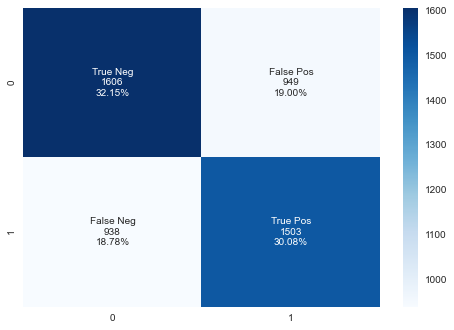

In [34]:
log_matrix= metrics.confusion_matrix(y_true=y_test_pca_,y_pred=log_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in log_matrix.flatten()]
group_percent = ["{0:.2%}".format(value) for value in log_matrix.flatten()/np.sum(log_matrix)]

labels = [[f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percent)]]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(log_matrix,annot=labels, fmt='', cmap='Blues')

###### XGBoost
###### Finding best params with RandommizedSearchCV
for this notebook I decided to use RandomizedSearchCV, becuse GridSearchCV run was too long (sometimes even 12 hours).

In [37]:
params = {'n_estimators':range(1,200,2),'max_depth':range(1,50,2)}
#grid_xgb = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False,eval_metric='mlogloss'),param_grid=params,cv=5,return_train_score=False,)
#grid_xgb.fit(x_train_pca_,y_train_pca_.ravel())
rgrid_xgb = RandomizedSearchCV(estimator=XGBClassifier(use_label_encoder=False,eval_metric = 'mlogloss'), param_distributions=params, scoring= 'accuracy',
                              n_jobs=-1, cv = 5)
rgrid_xgb.fit(x_train_pca_,y_train_pca_)
print(rgrid_xgb.best_estimator_, rgrid_xgb.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=9, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=193, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None) 0.6404952738577958


In [39]:
xgb_clf_ = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=9, min_child_weight=1,
              monotone_constraints='()', n_estimators=193, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)
xgb_clf_.fit(x_train_pca_, y_train_pca_)
xgb_pred_ = xgb_clf_.predict(x_test_pca_)

In [40]:
xgb_score = metrics.accuracy_score(y_true=y_test_pca_,y_pred=xgb_pred_)
xgb_recall = metrics.recall_score(y_true=y_test_pca_,y_pred=xgb_pred_)
xgb_percision = metrics.precision_score(y_true=y_test_pca_,y_pred=xgb_pred_)
xgb_f1 = metrics.f1_score(y_true=y_test_pca_,y_pred=xgb_pred_)
xgb_scores = pd.DataFrame(index = ['xgb'], data = {'score':xgb_score,'recall':xgb_recall,'percision':xgb_percision,'f1':xgb_f1})
xgb_scores

score    recall  percision        f1
xgb  0.654524  0.660795   0.642374  0.651454

<AxesSubplot:>

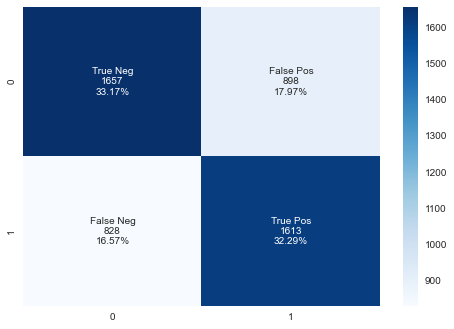

In [41]:
xgb_matrix= metrics.confusion_matrix(y_true=y_test_pca_,y_pred=xgb_pred_)
group_names_xgb = ['True Neg','False Pos','False Neg','True Pos']
group_counts_xgb = ["{0:0.0f}".format(value) for value in xgb_matrix.flatten()]
group_percent_xgb = ["{0:.2%}".format(value) for value in xgb_matrix.flatten()/np.sum(xgb_matrix)]

labels = [[f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names_xgb,group_counts_xgb,group_percent_xgb)]]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(xgb_matrix,annot=labels, fmt='', cmap='Blues')

###### Stacking

In [44]:
#find the hyper parameters to RandomForestClassifier
params_rnd = {'n_estimators':range(1,200,2),'min_samples_split':range(1,100,2)}
rnd_rgrid = RandomizedSearchCV(estimator=RandomForestClassifier(),param_distributions=params_rnd, n_jobs=-1, cv =5)
rnd_rgrid.fit(x_train_pca_,y_train_pca_)
print(rnd_rgrid.best_estimator_,"\n",rnd_rgrid.best_score_,"\n",rnd_rgrid.best_params_)

RandomForestClassifier(min_samples_split=49, n_estimators=177) 
 0.6083174367762809 
 {'n_estimators': 177, 'min_samples_split': 49}


In [46]:
estimators = [('rf', RandomForestClassifier(n_estimators=177,min_samples_split=49, random_state=42))
              ,('knn',KNeighborsClassifier())]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [47]:
stacking_clf.fit(x_train_pca_, y_train_pca_)
stack_pred = stacking_clf.predict(x_test_pca_)

In [48]:
stack_score = metrics.accuracy_score(y_true=y_test_pca_,y_pred=stack_pred)
stack_recall = metrics.recall_score(y_true=y_test_pca_,y_pred=stack_pred)
stack_percision = metrics.precision_score(y_true=y_test_pca_,y_pred=stack_pred)
stack_f1 = metrics.f1_score(y_true=y_test_pca_,y_pred=stack_pred)
stack_scores = pd.DataFrame(index = ['stacking'], data = {'score':stack_score,'recall':stack_recall,'percision':stack_percision,'f1':stack_f1})
stack_scores

score    recall  percision        f1
stacking  0.602882  0.680459   0.579756  0.626084

<AxesSubplot:>

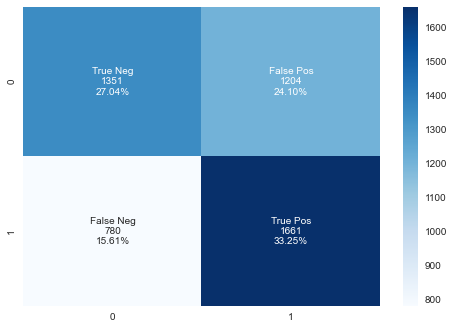

In [49]:
stack_matrix= metrics.confusion_matrix(y_true=y_test_pca_,y_pred=stack_pred)
group_names_stack = ['True Neg','False Pos','False Neg','True Pos']
group_counts_stack = ["{0:0.0f}".format(value) for value in stack_matrix.flatten()]
group_percent_stack = ["{0:.2%}".format(value) for value in stack_matrix.flatten()/np.sum(stack_matrix)]

labels = [[f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names_stack,group_counts_stack,group_percent_stack)]]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(stack_matrix,annot=labels, fmt='', cmap='Blues')

###### VotingClassifier

In [50]:
estimators_ = [('lr', log_reg),('xgb',xgb_clf_),('st',stacking_clf)]

voting_clf = VotingClassifier(estimators=estimators_,voting='soft')
voting_clf. fit(x_train_pca_, y_train_pca_)
voting_pred = voting_clf.predict(x_test_pca_)

In [51]:
voting_score = metrics.accuracy_score(y_true=y_test_pca_,y_pred=voting_pred)
voting_recall = metrics.recall_score(y_true=y_test_pca_,y_pred=voting_pred)
voting_percision = metrics.precision_score(y_true=y_test_pca_,y_pred=voting_pred)
voting_f1 = metrics.f1_score(y_true=y_test_pca_,y_pred=voting_pred)
voting_scores = pd.DataFrame(index = ['voting'], data = {'score':voting_score,'recall':voting_recall,'percision':voting_percision,'f1':voting_f1})
voting_scores

score   recall  percision        f1
voting  0.664331  0.66653   0.653414  0.659907

In [52]:
pd.concat([log_scores,xgb_scores,stack_scores,voting_scores])

score    recall  percision        f1
log_reg   0.622298  0.615731   0.612969  0.614347
xgb       0.654524  0.660795   0.642374  0.651454
stacking  0.602882  0.680459   0.579756  0.626084
voting    0.664331  0.666530   0.653414  0.659907